# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, \
    RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Normalize

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
import torchvision.transforms.functional as TF

class MyScaleTransform:
    """Take image and return values ranging from -1 to 1"""

    def __init__(self): #https://stackoverflow.com/questions/42884795/python-empty-constructor
        pass

    def __call__(self, x):
        return 2.0*(TF.to_tensor(x) - 0.5)


def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [MyScaleTransform()]#,
                  #RandomHorizontalFlip(), # https://arxiv.org/pdf/1511.06434.pdf advises against augmentation
                  #RandomVerticalFlip()]

    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
import os

class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.root_dir = directory
        self.transform = transforms
        self.extension = extension

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        # https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
        return len([name for name in os.listdir(self.root_dir) if self.extension in name])

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_path = os.path.join(data_dir, 'new_folder_with_items/' 
                                + str(int(1e6 + index + 1))[1:] # adds leading zeros to image path
                                + self.extension)
        image = Image.open(img_path)
        return self.transform(image)

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

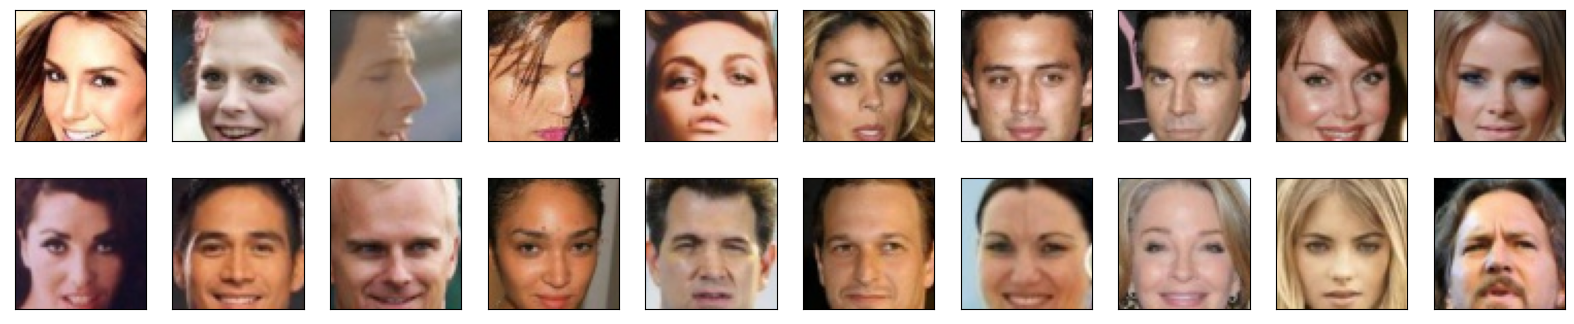

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy() 
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module

import torch.nn as nn
import torch.nn.functional as F

In [51]:
# follows from DCGAN_Exercise.ipynb
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        first_conv_out_channels = 128
        second_conv_out_channels = 256
        third_conv_out_channels = 512
        fourth_conv_out_channels = 1024

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=first_conv_out_channels,
                               kernel_size=5,
                               stride=2,
                               padding=2) # LxW is 32x32
        
        self.conv2 = nn.Conv2d(in_channels=first_conv_out_channels,
                               out_channels=second_conv_out_channels,
                               kernel_size=5,
                               stride=2,
                               padding=2) # LxW is 16x16
        self.batchnorm2 = nn.BatchNorm2d(second_conv_out_channels)

        self.conv3 = nn.Conv2d(in_channels=second_conv_out_channels,
                               out_channels=third_conv_out_channels,
                               kernel_size=5,
                               stride=2,
                               padding=2) # LxW is 8x8
        self.batchnorm3 = nn.BatchNorm2d(third_conv_out_channels)

        self.conv4 = nn.Conv2d(in_channels=third_conv_out_channels,
                               out_channels=fourth_conv_out_channels,
                               kernel_size=5,
                               stride=2,
                               padding=2) # LxW is 4x4
        self.batchnorm4 = nn.BatchNorm2d(fourth_conv_out_channels)          

        self.fc1 = nn.Linear(in_features=4*4*fourth_conv_out_channels,
                             out_features=1)      
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.batchnorm2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.batchnorm3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.batchnorm4(self.conv4(x)), 0.2)        

        x = torch.flatten(x, 1)

        x = self.fc1(x) # per note, no activation fxn. will ult. use BCE w LL
        x = torch.unsqueeze(x, 2) # adding two dims to pass tests
        x = torch.unsqueeze(x, 3)
        return x 

In [71]:
# The following test scripts were used to ascertain the dimensions of the intermediate outputs

In [19]:
images = torch.randn(1, 3, 64, 64) # (batch, channels, length, height)
after_conv1_discriminator = Discriminator()
print(after_conv1_discriminator(images).shape)

torch.Size([1, 128, 32, 32])


In [25]:
after_conv2_discriminator = Discriminator()
print(after_conv2_discriminator(images).shape)

torch.Size([1, 256, 16, 16])


In [39]:
after_conv3_discriminator = Discriminator()
print(after_conv3_discriminator(images).shape)

torch.Size([128, 512, 8, 8])


In [49]:
images = torch.randn(1, 3, 64, 64) # (batch, channels, length, height)
after_conv4_discriminator = Discriminator()
print(after_conv4_discriminator(images).shape)

torch.Size([1, 1024, 4, 4])


In [50]:
images = torch.randn(128, 3, 64, 64)
print(after_conv4_discriminator(images).shape)

torch.Size([128, 1024, 4, 4])


In [52]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must output **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as is often with GANs, **Batch Normalization** helps with training

In [59]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers

        self.first_conv_in_channels = 1024 
        first_conv_out_channels = 512 
        second_conv_out_channels = 256 
        third_conv_out_channels = 128 # rgb
        fourth_conv_out_channels = 3 # rgb

        self.fc1 = nn.Linear(in_features=latent_dim,
                             out_features=4*4*self.first_conv_in_channels)
        
        self.transpose_conv1 = nn.ConvTranspose2d(
                                    in_channels=self.first_conv_in_channels,
                                    out_channels=first_conv_out_channels,
                                    kernel_size=2,
                                    padding=0,
                                    stride=2)
        self.batch_norm1 = nn.BatchNorm2d(first_conv_out_channels)

        self.transpose_conv2 = nn.ConvTranspose2d(
                                    in_channels=first_conv_out_channels,
                                    out_channels=second_conv_out_channels,
                                    kernel_size=2,
                                    padding=0,
                                    stride=2)
        self.batch_norm2 = nn.BatchNorm2d(second_conv_out_channels)

        self.transpose_conv3 = nn.ConvTranspose2d(
                                    in_channels=second_conv_out_channels,
                                    out_channels=third_conv_out_channels,
                                    kernel_size=2,
                                    padding=0,
                                    stride=2)
        self.batch_norm3 = nn.BatchNorm2d(third_conv_out_channels)  

        self.transpose_conv4 = nn.ConvTranspose2d(
                                    in_channels=third_conv_out_channels,
                                    out_channels=fourth_conv_out_channels,
                                    kernel_size=2,
                                    padding=0,
                                    stride=2)                

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        batch_size = len(x)
        x = x.view(batch_size, self.first_conv_in_channels, 4, 4) # order based on https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d

        x = F.relu(self.batch_norm1(self.transpose_conv1(x)))
        x = F.relu(self.batch_norm2(self.transpose_conv2(x)))
        x = F.relu(self.batch_norm3(self.transpose_conv3(x)))
        x = F.tanh(self.transpose_conv4(x))
        
        return x

In [72]:
# Using the formula from:
# https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

In [58]:
def H_out(H_in, S, P, K):
    return (H_in - 1)*S - 2*P + 1*(K - 1) + 1

H = H_out(H_in=4, S=2, P=0, K=2)
print(H)

H = H_out(H_in=8, S=2, P=0, K=2)
print(H)

H = H_out(H_in=16, S=2, P=0, K=2)
print(H)

H = H_out(H_in=32, S=2, P=0, K=2)
print(H)

8
16
32
64


In [60]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim) 

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [61]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers

    # params
    lr = 0.0002 # 0.0002 # https://arxiv.org/pdf/1511.06434.pdf
    beta1 = 0.5 # https://arxiv.org/pdf/1511.06434.pdf
    beta2 = 0.999 # default value

    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [62]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    # follows real_loss and fake_loss from MNIST_GAN_Exercise.ipynb
    labels = torch.ones(fake_logits.size())*0.9
    labels = labels.cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    loss = criterion(fake_logits.squeeze(), labels.squeeze())    
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [63]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 

    criterion = torch.nn.BCEWithLogitsLoss()

    # real_loss
    labels = torch.ones(real_logits.size())*0.9
    labels = labels.cuda()
    real_loss = criterion(real_logits.squeeze(), labels.squeeze())

    # fake_loss
    labels = torch.zeros(fake_logits.size())
    labels = labels.cuda()
    fake_loss = criterion(fake_logits.squeeze(), labels.squeeze())

    loss = real_loss + fake_loss

    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [ ]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [64]:
def generator_step(batch_size: int, latent_dim: int, 
                   generator: Module, 
                   discriminator: Module, 
                   g_optimizer: optim.Adam) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    z = torch.from_numpy(z).float()
    z = z.cuda()
    fake_images = generator(z)

    fake_images = fake_images.cuda() 
    g_optimizer.zero_grad()         

    # Compute the discriminator losses on fake images 
    # using flipped labels!
    
    # perform backprop
    g_loss = generator_loss(discriminator(fake_images))
    g_loss.backward()
    g_optimizer.step()
        
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor,
                       generator: Module, 
                       discriminator: Module, 
                       d_optimizer: optim.Adam) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)

    real_images = real_images.cuda()
    d_optimizer.zero_grad()
    
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    z = torch.from_numpy(z).float()
    z = z.cuda()
    fake_images = generator(z)

    fake_images = fake_images.cuda()       

    d_loss = discriminator_loss(real_logits=discriminator(real_images), 
                       fake_logits=discriminator(fake_images))       

    d_loss.backward()
    d_optimizer.step()

    gp = 0 # rather than implement gradient penalty yet

    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [65]:
from datetime import datetime

In [66]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64

In [67]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device) 
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [68]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-05-16 13:20:15 | Epoch [1/10] | Batch 0/509 | d_loss: 1.4784 | g_loss: 0.9105
2023-05-16 13:20:20 | Epoch [1/10] | Batch 50/509 | d_loss: 1.1782 | g_loss: 5.2176
2023-05-16 13:20:25 | Epoch [1/10] | Batch 100/509 | d_loss: 0.4013 | g_loss: 12.9410
2023-05-16 13:20:31 | Epoch [1/10] | Batch 150/509 | d_loss: 0.3457 | g_loss: 5.7306
2023-05-16 13:20:36 | Epoch [1/10] | Batch 200/509 | d_loss: 0.3487 | g_loss: 6.4932
2023-05-16 13:20:41 | Epoch [1/10] | Batch 250/509 | d_loss: 0.5233 | g_loss: 3.8354
2023-05-16 13:20:47 | Epoch [1/10] | Batch 300/509 | d_loss: 0.4383 | g_loss: 3.0418
2023-05-16 13:20:52 | Epoch [1/10] | Batch 350/509 | d_loss: 0.7886 | g_loss: 1.7884
2023-05-16 13:20:57 | Epoch [1/10] | Batch 400/509 | d_loss: 2.1582 | g_loss: 6.2699
2023-05-16 13:21:03 | Epoch [1/10] | Batch 450/509 | d_loss: 0.4407 | g_loss: 4.0056
2023-05-16 13:21:08 | Epoch [1/10] | Batch 500/509 | d_loss: 0.6017 | g_loss: 2.7978


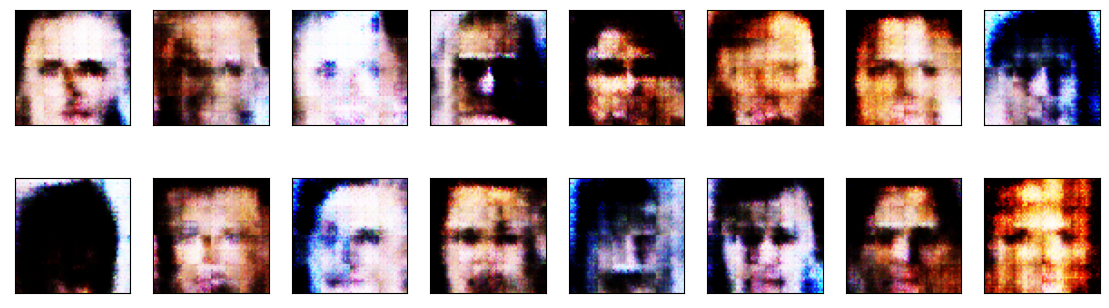

2023-05-16 13:21:10 | Epoch [2/10] | Batch 0/509 | d_loss: 0.4213 | g_loss: 3.9097
2023-05-16 13:21:15 | Epoch [2/10] | Batch 50/509 | d_loss: 0.7301 | g_loss: 5.4201
2023-05-16 13:21:20 | Epoch [2/10] | Batch 100/509 | d_loss: 0.4345 | g_loss: 3.1855
2023-05-16 13:21:26 | Epoch [2/10] | Batch 150/509 | d_loss: 0.4930 | g_loss: 4.3479
2023-05-16 13:21:31 | Epoch [2/10] | Batch 200/509 | d_loss: 0.4775 | g_loss: 2.8046
2023-05-16 13:21:36 | Epoch [2/10] | Batch 250/509 | d_loss: 0.3664 | g_loss: 3.7996
2023-05-16 13:21:42 | Epoch [2/10] | Batch 300/509 | d_loss: 0.9102 | g_loss: 2.0218
2023-05-16 13:21:47 | Epoch [2/10] | Batch 350/509 | d_loss: 0.4014 | g_loss: 2.4491
2023-05-16 13:21:53 | Epoch [2/10] | Batch 400/509 | d_loss: 0.3629 | g_loss: 3.9765
2023-05-16 13:21:58 | Epoch [2/10] | Batch 450/509 | d_loss: 0.5958 | g_loss: 2.9494
2023-05-16 13:22:03 | Epoch [2/10] | Batch 500/509 | d_loss: 0.3859 | g_loss: 6.5067


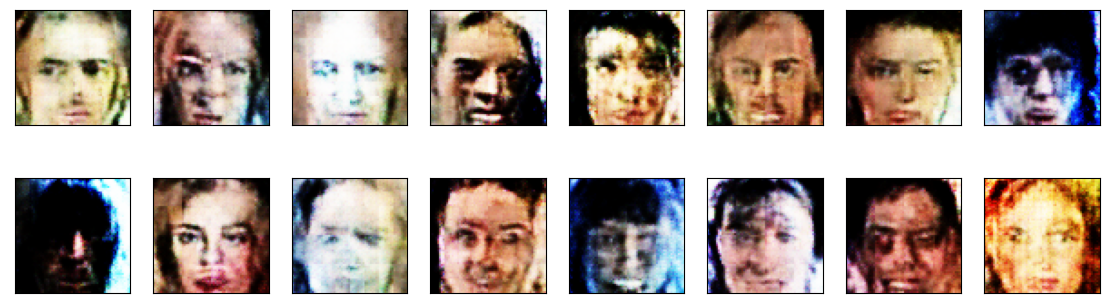

2023-05-16 13:22:05 | Epoch [3/10] | Batch 0/509 | d_loss: 0.5090 | g_loss: 4.8259
2023-05-16 13:22:10 | Epoch [3/10] | Batch 50/509 | d_loss: 0.5938 | g_loss: 2.7940
2023-05-16 13:22:16 | Epoch [3/10] | Batch 100/509 | d_loss: 0.4871 | g_loss: 5.1321
2023-05-16 13:22:21 | Epoch [3/10] | Batch 150/509 | d_loss: 0.3659 | g_loss: 3.9812
2023-05-16 13:22:26 | Epoch [3/10] | Batch 200/509 | d_loss: 0.6525 | g_loss: 3.0240
2023-05-16 13:22:32 | Epoch [3/10] | Batch 250/509 | d_loss: 0.4014 | g_loss: 4.3715
2023-05-16 13:22:37 | Epoch [3/10] | Batch 300/509 | d_loss: 0.4527 | g_loss: 5.3976
2023-05-16 13:22:43 | Epoch [3/10] | Batch 350/509 | d_loss: 0.5612 | g_loss: 3.2422
2023-05-16 13:22:48 | Epoch [3/10] | Batch 400/509 | d_loss: 0.6073 | g_loss: 2.0916
2023-05-16 13:22:54 | Epoch [3/10] | Batch 450/509 | d_loss: 0.4520 | g_loss: 3.1926
2023-05-16 13:22:59 | Epoch [3/10] | Batch 500/509 | d_loss: 0.6187 | g_loss: 5.3173


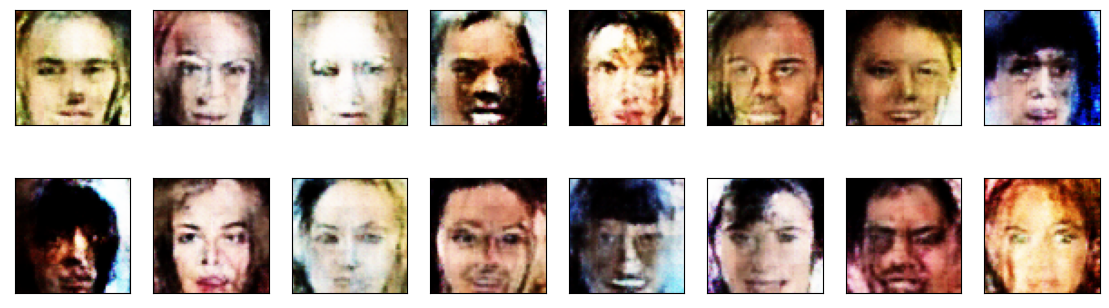

2023-05-16 13:23:00 | Epoch [4/10] | Batch 0/509 | d_loss: 0.6371 | g_loss: 2.2196
2023-05-16 13:23:06 | Epoch [4/10] | Batch 50/509 | d_loss: 0.4053 | g_loss: 4.4724
2023-05-16 13:23:11 | Epoch [4/10] | Batch 100/509 | d_loss: 2.7411 | g_loss: 8.5817
2023-05-16 13:23:17 | Epoch [4/10] | Batch 150/509 | d_loss: 0.3763 | g_loss: 3.6809
2023-05-16 13:23:22 | Epoch [4/10] | Batch 200/509 | d_loss: 0.3773 | g_loss: 5.2154
2023-05-16 13:23:28 | Epoch [4/10] | Batch 250/509 | d_loss: 0.4167 | g_loss: 3.3856
2023-05-16 13:23:33 | Epoch [4/10] | Batch 300/509 | d_loss: 0.5601 | g_loss: 2.5361
2023-05-16 13:23:38 | Epoch [4/10] | Batch 350/509 | d_loss: 0.4381 | g_loss: 3.2232
2023-05-16 13:23:44 | Epoch [4/10] | Batch 400/509 | d_loss: 0.3660 | g_loss: 5.1227
2023-05-16 13:23:49 | Epoch [4/10] | Batch 450/509 | d_loss: 0.4213 | g_loss: 4.4572
2023-05-16 13:23:55 | Epoch [4/10] | Batch 500/509 | d_loss: 0.4100 | g_loss: 4.1811


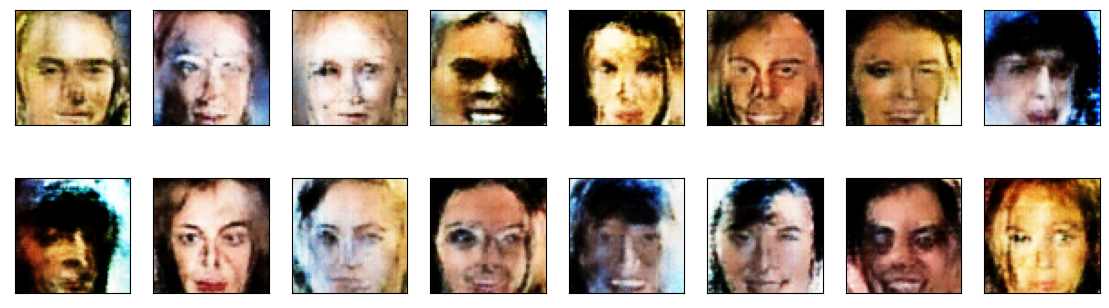

2023-05-16 13:23:56 | Epoch [5/10] | Batch 0/509 | d_loss: 0.5131 | g_loss: 5.4628
2023-05-16 13:24:02 | Epoch [5/10] | Batch 50/509 | d_loss: 0.5215 | g_loss: 3.2548
2023-05-16 13:24:07 | Epoch [5/10] | Batch 100/509 | d_loss: 0.7236 | g_loss: 1.4725
2023-05-16 13:24:13 | Epoch [5/10] | Batch 150/509 | d_loss: 0.7057 | g_loss: 2.7567
2023-05-16 13:24:18 | Epoch [5/10] | Batch 200/509 | d_loss: 0.4640 | g_loss: 3.7729
2023-05-16 13:24:23 | Epoch [5/10] | Batch 250/509 | d_loss: 0.5185 | g_loss: 4.3001
2023-05-16 13:24:29 | Epoch [5/10] | Batch 300/509 | d_loss: 0.3909 | g_loss: 3.9885
2023-05-16 13:24:34 | Epoch [5/10] | Batch 350/509 | d_loss: 0.3996 | g_loss: 3.1128
2023-05-16 13:24:40 | Epoch [5/10] | Batch 400/509 | d_loss: 0.4264 | g_loss: 3.7773
2023-05-16 13:24:45 | Epoch [5/10] | Batch 450/509 | d_loss: 0.3938 | g_loss: 3.5681
2023-05-16 13:24:51 | Epoch [5/10] | Batch 500/509 | d_loss: 0.3680 | g_loss: 5.1819


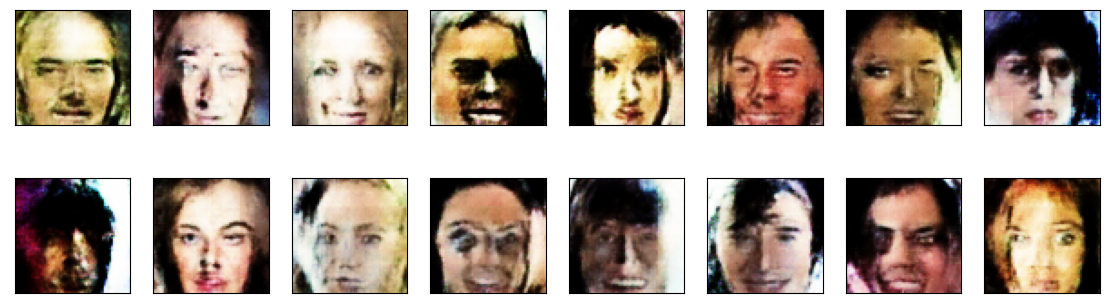

2023-05-16 13:24:52 | Epoch [6/10] | Batch 0/509 | d_loss: 0.3704 | g_loss: 4.0387
2023-05-16 13:24:58 | Epoch [6/10] | Batch 50/509 | d_loss: 0.3460 | g_loss: 4.3770
2023-05-16 13:25:03 | Epoch [6/10] | Batch 100/509 | d_loss: 0.4064 | g_loss: 3.4764
2023-05-16 13:25:08 | Epoch [6/10] | Batch 150/509 | d_loss: 0.3488 | g_loss: 5.3767
2023-05-16 13:25:14 | Epoch [6/10] | Batch 200/509 | d_loss: 0.4922 | g_loss: 5.6900
2023-05-16 13:25:19 | Epoch [6/10] | Batch 250/509 | d_loss: 0.4350 | g_loss: 2.5833
2023-05-16 13:25:25 | Epoch [6/10] | Batch 300/509 | d_loss: 0.3928 | g_loss: 3.4814
2023-05-16 13:25:30 | Epoch [6/10] | Batch 350/509 | d_loss: 0.4516 | g_loss: 4.6978
2023-05-16 13:25:36 | Epoch [6/10] | Batch 400/509 | d_loss: 0.8283 | g_loss: 3.0629
2023-05-16 13:25:41 | Epoch [6/10] | Batch 450/509 | d_loss: 0.4718 | g_loss: 3.8510
2023-05-16 13:25:47 | Epoch [6/10] | Batch 500/509 | d_loss: 0.3756 | g_loss: 4.1905


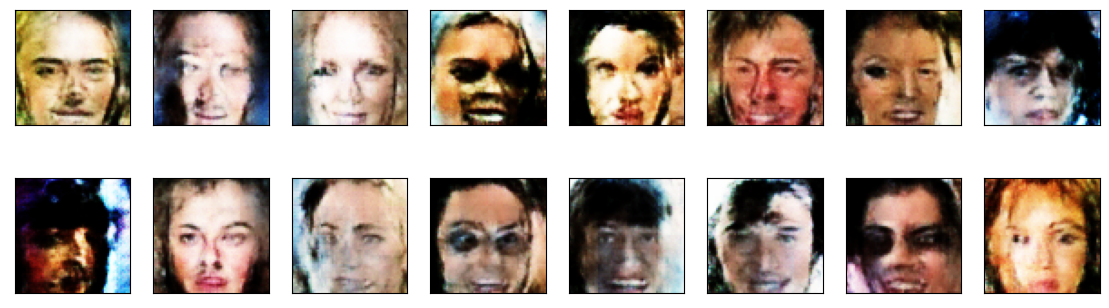

2023-05-16 13:25:48 | Epoch [7/10] | Batch 0/509 | d_loss: 0.3776 | g_loss: 4.1634
2023-05-16 13:25:54 | Epoch [7/10] | Batch 50/509 | d_loss: 0.3465 | g_loss: 5.0022
2023-05-16 13:25:59 | Epoch [7/10] | Batch 100/509 | d_loss: 0.4858 | g_loss: 5.3514
2023-05-16 13:26:04 | Epoch [7/10] | Batch 150/509 | d_loss: 0.3475 | g_loss: 5.6076
2023-05-16 13:26:10 | Epoch [7/10] | Batch 200/509 | d_loss: 0.3798 | g_loss: 6.1384
2023-05-16 13:26:15 | Epoch [7/10] | Batch 250/509 | d_loss: 0.3497 | g_loss: 6.2267
2023-05-16 13:26:21 | Epoch [7/10] | Batch 300/509 | d_loss: 0.3449 | g_loss: 4.5302
2023-05-16 13:26:26 | Epoch [7/10] | Batch 350/509 | d_loss: 0.3436 | g_loss: 5.2037
2023-05-16 13:26:32 | Epoch [7/10] | Batch 400/509 | d_loss: 0.3398 | g_loss: 4.7996
2023-05-16 13:26:37 | Epoch [7/10] | Batch 450/509 | d_loss: 0.5649 | g_loss: 2.8466
2023-05-16 13:26:43 | Epoch [7/10] | Batch 500/509 | d_loss: 0.5038 | g_loss: 4.0323


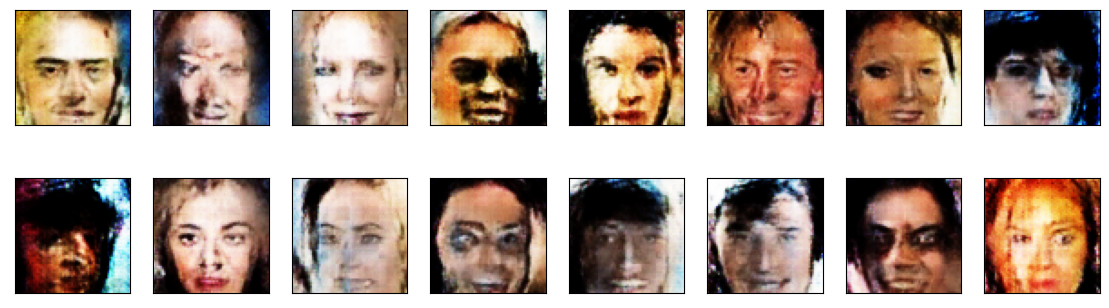

2023-05-16 13:26:44 | Epoch [8/10] | Batch 0/509 | d_loss: 0.8599 | g_loss: 5.2768
2023-05-16 13:26:50 | Epoch [8/10] | Batch 50/509 | d_loss: 0.4892 | g_loss: 3.0246
2023-05-16 13:26:55 | Epoch [8/10] | Batch 100/509 | d_loss: 0.4952 | g_loss: 2.3823
2023-05-16 13:27:00 | Epoch [8/10] | Batch 150/509 | d_loss: 0.5652 | g_loss: 4.1777
2023-05-16 13:27:06 | Epoch [8/10] | Batch 200/509 | d_loss: 0.3882 | g_loss: 4.3809
2023-05-16 13:27:11 | Epoch [8/10] | Batch 250/509 | d_loss: 0.6748 | g_loss: 4.8202
2023-05-16 13:27:17 | Epoch [8/10] | Batch 300/509 | d_loss: 0.3745 | g_loss: 4.2532
2023-05-16 13:27:22 | Epoch [8/10] | Batch 350/509 | d_loss: 0.3798 | g_loss: 4.3902
2023-05-16 13:27:28 | Epoch [8/10] | Batch 400/509 | d_loss: 0.3941 | g_loss: 3.4181
2023-05-16 13:27:33 | Epoch [8/10] | Batch 450/509 | d_loss: 0.4165 | g_loss: 4.5531
2023-05-16 13:27:39 | Epoch [8/10] | Batch 500/509 | d_loss: 0.3571 | g_loss: 5.0355


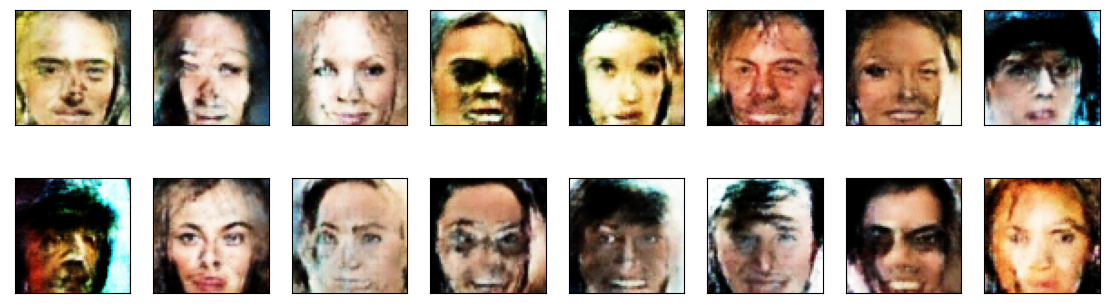

2023-05-16 13:27:40 | Epoch [9/10] | Batch 0/509 | d_loss: 0.3608 | g_loss: 4.1806
2023-05-16 13:27:46 | Epoch [9/10] | Batch 50/509 | d_loss: 0.4232 | g_loss: 5.3445
2023-05-16 13:27:51 | Epoch [9/10] | Batch 100/509 | d_loss: 0.3682 | g_loss: 5.5877
2023-05-16 13:27:57 | Epoch [9/10] | Batch 150/509 | d_loss: 0.3897 | g_loss: 4.2859
2023-05-16 13:28:02 | Epoch [9/10] | Batch 200/509 | d_loss: 0.4974 | g_loss: 3.5294
2023-05-16 13:28:08 | Epoch [9/10] | Batch 250/509 | d_loss: 0.5333 | g_loss: 4.9727
2023-05-16 13:28:13 | Epoch [9/10] | Batch 300/509 | d_loss: 0.3855 | g_loss: 3.1512
2023-05-16 13:28:18 | Epoch [9/10] | Batch 350/509 | d_loss: 0.3523 | g_loss: 4.5455
2023-05-16 13:28:24 | Epoch [9/10] | Batch 400/509 | d_loss: 0.4852 | g_loss: 4.1948
2023-05-16 13:28:29 | Epoch [9/10] | Batch 450/509 | d_loss: 0.3877 | g_loss: 5.5891
2023-05-16 13:28:35 | Epoch [9/10] | Batch 500/509 | d_loss: 0.4119 | g_loss: 4.6551


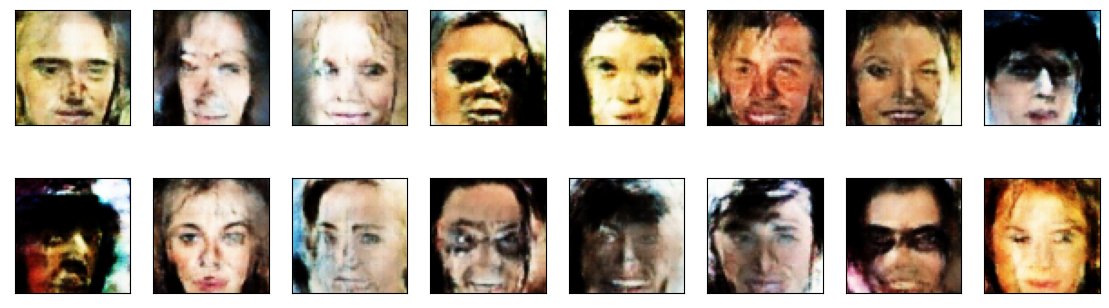

2023-05-16 13:28:36 | Epoch [10/10] | Batch 0/509 | d_loss: 0.3470 | g_loss: 6.0158
2023-05-16 13:28:42 | Epoch [10/10] | Batch 50/509 | d_loss: 0.5265 | g_loss: 2.3515
2023-05-16 13:28:47 | Epoch [10/10] | Batch 100/509 | d_loss: 0.4184 | g_loss: 3.1843
2023-05-16 13:28:53 | Epoch [10/10] | Batch 150/509 | d_loss: 0.3576 | g_loss: 5.1998
2023-05-16 13:28:58 | Epoch [10/10] | Batch 200/509 | d_loss: 0.4061 | g_loss: 4.7449
2023-05-16 13:29:04 | Epoch [10/10] | Batch 250/509 | d_loss: 0.3424 | g_loss: 4.7257
2023-05-16 13:29:09 | Epoch [10/10] | Batch 300/509 | d_loss: 0.3446 | g_loss: 4.9915
2023-05-16 13:29:14 | Epoch [10/10] | Batch 350/509 | d_loss: 0.4790 | g_loss: 5.5306
2023-05-16 13:29:20 | Epoch [10/10] | Batch 400/509 | d_loss: 0.4547 | g_loss: 3.4454
2023-05-16 13:29:25 | Epoch [10/10] | Batch 450/509 | d_loss: 0.3560 | g_loss: 6.7688
2023-05-16 13:29:31 | Epoch [10/10] | Batch 500/509 | d_loss: 0.3411 | g_loss: 4.5400


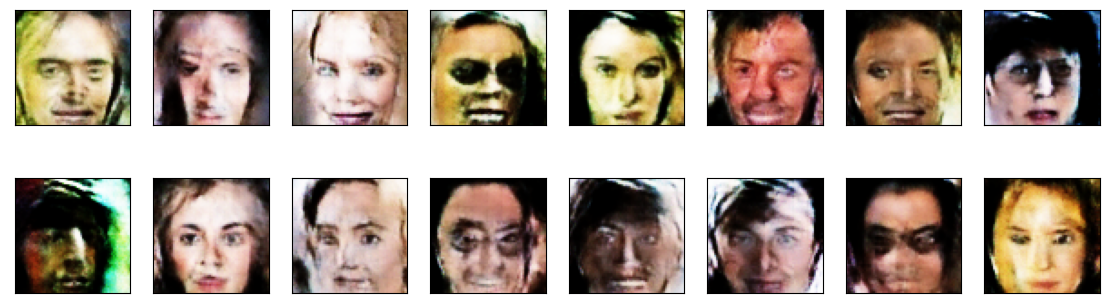

In [69]:
####
# TRAIN HERE OR USING THE CLASS IMPLEMENTATION IN THE BLOCK BELOW
####

fixed_latent_vector = torch.randn(batch_size, latent_dim, 1, 1).float().cuda()

losses = []
d = 100
g = 100
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################

        g_loss = generator_step(batch_size, latent_dim, generator, discriminator, g_optimizer)
        d_loss = discriminator_step(batch_size, latent_dim, real_images, 
                                    generator, discriminator, d_optimizer)

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

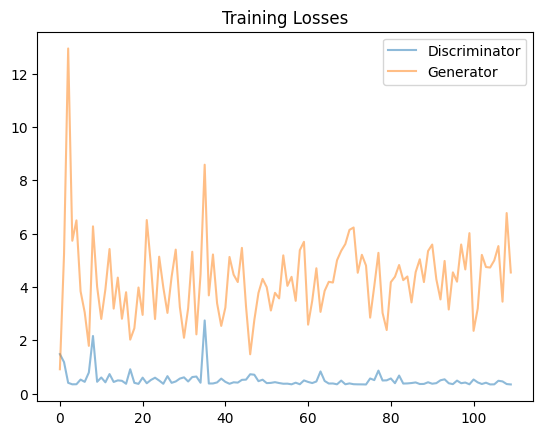

In [70]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** The biggest issue with the generated samples is the blotchiness around the lips and eyes. To improve upon this model, the focus should be on gathering higher resolution data. One approach may be to interpolate the existing images in either image-space or k-space (i.e., the Fourier domain). Instead of a 64x64 image, the input images may be 128x128 or 256x256. More convolutional and deconvolutional operators will be needed in the discriminator and generator, respectively, so that the length and width dimensions can scale by a factor of one-half or two. Noteworthy is that the network trained using much of the parameters in the referenced [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), but smaller networks with differing kernel sizes were difficult to train. Perhaps an even larger network will not face these difficulties. Separately, GPU usage needs to accommodate the large number of weight elements, either by halving precision or using multiple GPUs.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.